# Sobel Filter auf Spielkarten mit PyTorch Conv2D

In diesem Notebook werden Spielkartenbilder (Herz Dame und Pik Ass) heruntergeladen und mit Sobel-Filtern (Gx und Gy) bearbeitet:
1. Sobel-Filter auf dem Rotkanal
2. Sobel-Filter auf allen drei Farbkanälen

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Lade Herz Dame von lokaler Datei...
Lade Pik Ass von lokaler Datei...


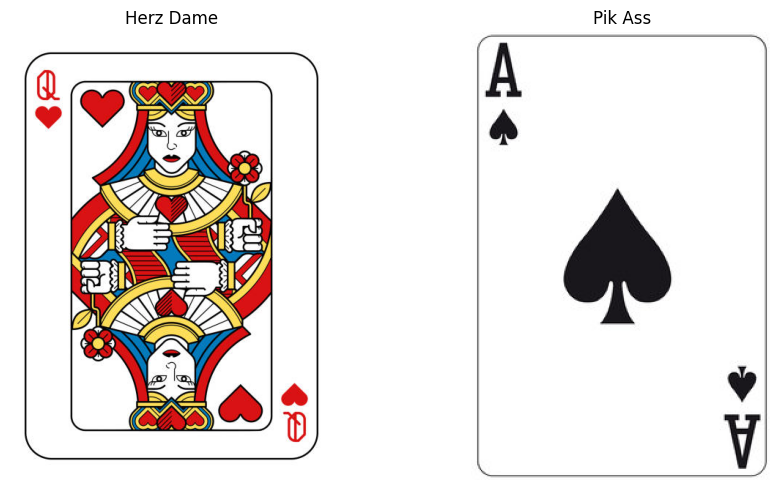

Größe Herz Dame: (441, 612)
Größe Pik Ass: (242, 360)


In [2]:
# Lokale Spielkartenbilder laden
# Bilder einlesen
print("Lade Herz Dame von lokaler Datei...")
queen_hearts = Image.open('herzDame.jpg').convert('RGB')
print("Lade Pik Ass von lokaler Datei...")
ace_spades = Image.open('peakAss.jpg').convert('RGB')

# Bilder anzeigen
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(queen_hearts)
axes[0].set_title('Herz Dame')
axes[0].axis('off')
axes[1].imshow(ace_spades)
axes[1].set_title('Pik Ass')
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f"Größe Herz Dame: {queen_hearts.size}")
print(f"Größe Pik Ass: {ace_spades.size}")

In [3]:
# Bilder zu gleicher Größe skalieren und zu Tensoren konvertieren
def image_to_tensor(img, size=(256, 256)):
    """Konvertiert PIL Image zu PyTorch Tensor mit Shape (1, C, H, W)"""
    # Größe anpassen
    img_resized = img.resize(size, Image.BILINEAR)
    # Zu NumPy Array (H, W, C) mit Werten 0-255
    img_array = np.array(img_resized, dtype=np.float32)
    # Normalisieren zu 0-1
    img_array = img_array / 255.0
    # Umformen zu (C, H, W)
    img_array = np.transpose(img_array, (2, 0, 1))
    # Zu Tensor konvertieren und Batch-Dimension hinzufügen (1, C, H, W)
    tensor = torch.from_numpy(img_array).unsqueeze(0)
    return tensor

# Konvertiere beide Bilder zu Tensoren
queen_tensor = image_to_tensor(queen_hearts)
ace_tensor = image_to_tensor(ace_spades)

print(f"Queen Tensor Shape: {queen_tensor.shape}")
print(f"Ace Tensor Shape: {ace_tensor.shape}")
print(f"Tensor Wertebereich: [{queen_tensor.min():.3f}, {queen_tensor.max():.3f}]")

Queen Tensor Shape: torch.Size([1, 3, 256, 256])
Ace Tensor Shape: torch.Size([1, 3, 256, 256])
Tensor Wertebereich: [0.000, 1.000]


In [4]:
# Sobel Filter Kernel definieren
# Sobel Gx (vertikale Kanten)
sobel_gx = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

# Sobel Gy (horizontale Kanten)
sobel_gy = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float32)

print("Sobel Gx Kernel:")
print(sobel_gx)
print("\nSobel Gy Kernel:")
print(sobel_gy)

Sobel Gx Kernel:
[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]

Sobel Gy Kernel:
[[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  1.]]


In [18]:
# Conv2D Layer vorbereiten
# Wir brauchen:
# - 1 Kanal Eingang (Rotkanal) -> Gx und Gy = 2 Filter
# - 3 Kanäle Eingang (RGB) -> Gx und Gy = 2 Filter
# Insgesamt: 4 Output-Kanäle (2 für Rotkanal, 2 für RGB)

# Wir erstellen einen Conv2D Layer mit:
# - in_channels = 3 (RGB)
# - out_channels = 4 (2 für Rotkanal: Gx und Gy, 2 für RGB: Gx und Gy)
# - kernel_size = 3x3
# - padding = 1 (um Größe beizubehalten)
# - bias = False (Sobel Filter benötigt kein Bias)

conv_layer = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1, bias=False)

# Gewichte als Tensor vorbereiten
weight_tensor = torch.zeros(4, 3, 3, 3)

# Filter 0: Gx auf Rotkanal (nur R-Kanal aktiv)
weight_tensor[0, 0, :, :] = torch.from_numpy(sobel_gx)  # R-Kanal

# Filter 1: Gy auf Rotkanal (nur R-Kanal aktiv)
weight_tensor[1, 0, :, :] = torch.from_numpy(sobel_gy)  # R-Kanal

# Filter 2: Gx auf allen RGB-Kanälen
weight_tensor[2, 0, :, :] = torch.from_numpy(sobel_gx)  # R-Kanal
weight_tensor[2, 1, :, :] = torch.from_numpy(sobel_gx)  # G-Kanal
weight_tensor[2, 2, :, :] = torch.from_numpy(sobel_gx)  # B-Kanal

# Filter 3: Gy auf allen RGB-Kanälen
weight_tensor[3, 0, :, :] = torch.from_numpy(sobel_gy)  # R-Kanal
weight_tensor[3, 1, :, :] = torch.from_numpy(sobel_gy)  # G-Kanal
weight_tensor[3, 2, :, :] = torch.from_numpy(sobel_gy)  # B-Kanal

# State dict laden
conv_layer.load_state_dict({'weight': weight_tensor})

print("Conv2D Layer erstellt (via state_dict):")
print(f"Input Channels: 3 (RGB)")
print(f"Output Channels: 4 (Rotkanal Gx, Rotkanal Gy, RGB Gx, RGB Gy)")
print(f"Kernel Size: 3x3")
print(f"Weight Shape: {conv_layer.weight.shape}")  # (4, 3, 3, 3)

# Tensor visualisieren (ähnlich TorchFilterLabor Zelle 11)
print("\n--- Rohes weight_tensor ---")
print(weight_tensor)

print("\n--- Visualisierung der Dimensionen ---")
print(f"Shape = {weight_tensor.shape} -> (out_channels, in_channels, height, width)")
print("Bedeutung der Dimensionen:")
print("[")
print("  [   ← Dimension 0: out_channels = 4 (jeder Output-Feature-Map / Filter)")
print("    [   ← Dimension 1: in_channels = 3 (Eingangs-Farbkanäle R,G,B)")
print("      [   ← Dimension 2: height = 3 (Kernel-Höhe)")
print("        [w00, w01, w02],  ← Dimension 3: width = 3 (Kernel-Breite)")
print("        [w10, w11, w12],")
print("        [w20, w21, w22]")
print("      ]")
print("    ]")
print("  ]")
print("]")

channel_names = ['R','G','B']
for f in range(weight_tensor.shape[0]):
    print(f"\n=== Filter {f} ===")
    for c in range(weight_tensor.shape[1]):
        print(f"  Kanal {channel_names[c]} (Filter {f}, Channel {c}):")
        print(weight_tensor[f, c])

print("\n--- State Dict (Gewichte) ---")
state_dict = conv_layer.state_dict()
print(state_dict['weight'])


Conv2D Layer erstellt (via state_dict):
Input Channels: 3 (RGB)
Output Channels: 4 (Rotkanal Gx, Rotkanal Gy, RGB Gx, RGB Gy)
Kernel Size: 3x3
Weight Shape: torch.Size([4, 3, 3, 3])

--- Rohes weight_tensor ---
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]]],


        [[[-1., -2., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  2.,  1.]],

         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]]],


        [[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]],


        [[[-1., -2., -1.],
         

In [6]:
# Sobel Filter auf beide Bilder anwenden (nur EINMAL Conv2d aufrufen!)
# Kombiniere beide Bilder zu einem Batch
batch_input = torch.cat([queen_tensor, ace_tensor], dim=0)  # Shape: (2, 3, 256, 256)
print(f"Batch Input Shape: {batch_input.shape}")

# Einmaliger Aufruf von Conv2d
with torch.no_grad():
    sobel_results = conv_layer(batch_input)

print(f"Sobel Results Shape: {sobel_results.shape}")  # (2, 4, 256, 256)
print(f"  - 2 Bilder")
print(f"  - 4 Kanäle: [Rotkanal Gx, Rotkanal Gy, RGB Gx, RGB Gy]")
print(f"  - 256x256 Pixel")

# Ergebnisse extrahieren
queen_results = sobel_results[0]  # (4, 256, 256)
ace_results = sobel_results[1]    # (4, 256, 256)

# Einzelne Filter-Ergebnisse
queen_red_gx = queen_results[0].numpy()
queen_red_gy = queen_results[1].numpy()
queen_rgb_gx = queen_results[2].numpy()
queen_rgb_gy = queen_results[3].numpy()

ace_red_gx = ace_results[0].numpy()
ace_red_gy = ace_results[1].numpy()
ace_rgb_gx = ace_results[2].numpy()
ace_rgb_gy = ace_results[3].numpy()

print("\n✓ Sobel Filter erfolgreich angewendet (mit nur EINEM Conv2d Aufruf)")

Batch Input Shape: torch.Size([2, 3, 256, 256])
Sobel Results Shape: torch.Size([2, 4, 256, 256])
  - 2 Bilder
  - 4 Kanäle: [Rotkanal Gx, Rotkanal Gy, RGB Gx, RGB Gy]
  - 256x256 Pixel

✓ Sobel Filter erfolgreich angewendet (mit nur EINEM Conv2d Aufruf)


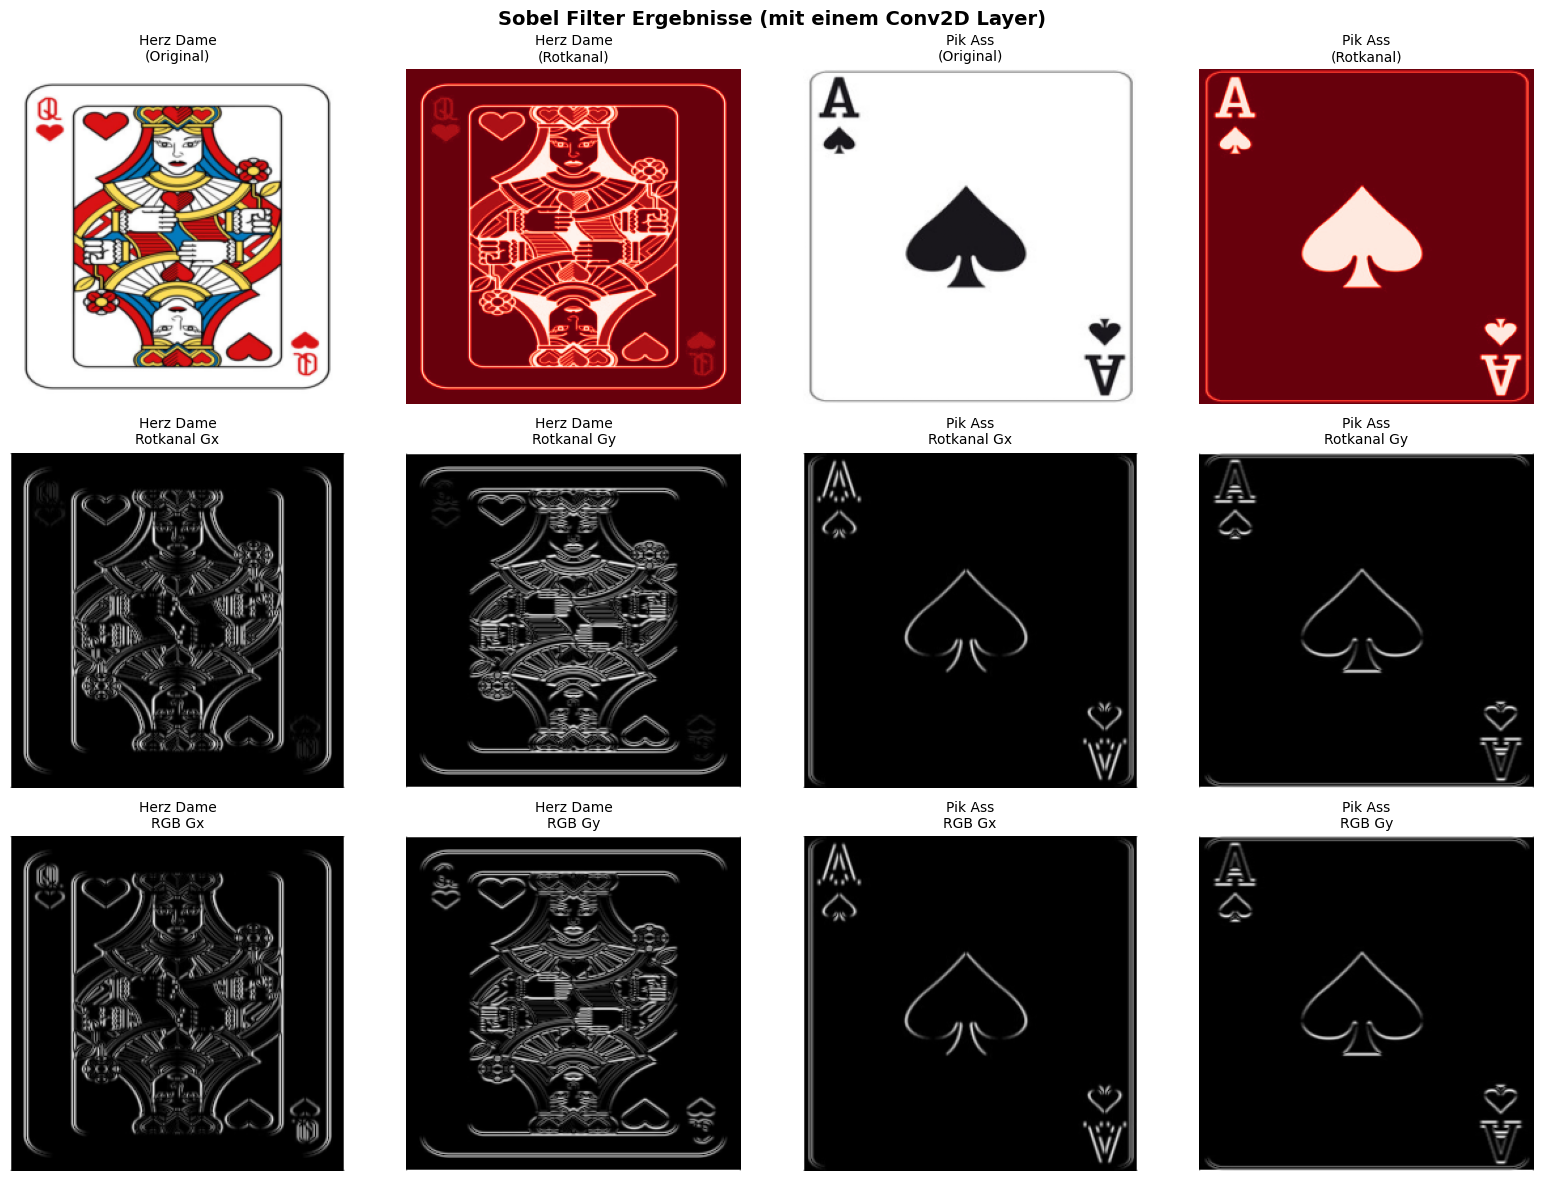

In [7]:
# Ergebnisse visualisieren mit matplotlib subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Zeile 0: Original-Bilder
axes[0, 0].imshow(queen_tensor[0].permute(1, 2, 0).numpy())
axes[0, 0].set_title('Herz Dame\n(Original)', fontsize=10)
axes[0, 0].axis('off')

axes[0, 1].imshow(queen_tensor[0, 0].numpy(), cmap='Reds')
axes[0, 1].set_title('Herz Dame\n(Rotkanal)', fontsize=10)
axes[0, 1].axis('off')

axes[0, 2].imshow(ace_tensor[0].permute(1, 2, 0).numpy())
axes[0, 2].set_title('Pik Ass\n(Original)', fontsize=10)
axes[0, 2].axis('off')

axes[0, 3].imshow(ace_tensor[0, 0].numpy(), cmap='Reds')
axes[0, 3].set_title('Pik Ass\n(Rotkanal)', fontsize=10)
axes[0, 3].axis('off')

# Zeile 1: Sobel auf Rotkanal
axes[1, 0].imshow(np.abs(queen_red_gx), cmap='gray')
axes[1, 0].set_title('Herz Dame\nRotkanal Gx', fontsize=10)
axes[1, 0].axis('off')

axes[1, 1].imshow(np.abs(queen_red_gy), cmap='gray')
axes[1, 1].set_title('Herz Dame\nRotkanal Gy', fontsize=10)
axes[1, 1].axis('off')

axes[1, 2].imshow(np.abs(ace_red_gx), cmap='gray')
axes[1, 2].set_title('Pik Ass\nRotkanal Gx', fontsize=10)
axes[1, 2].axis('off')

axes[1, 3].imshow(np.abs(ace_red_gy), cmap='gray')
axes[1, 3].set_title('Pik Ass\nRotkanal Gy', fontsize=10)
axes[1, 3].axis('off')

# Zeile 2: Sobel auf RGB
axes[2, 0].imshow(np.abs(queen_rgb_gx), cmap='gray')
axes[2, 0].set_title('Herz Dame\nRGB Gx', fontsize=10)
axes[2, 0].axis('off')

axes[2, 1].imshow(np.abs(queen_rgb_gy), cmap='gray')
axes[2, 1].set_title('Herz Dame\nRGB Gy', fontsize=10)
axes[2, 1].axis('off')

axes[2, 2].imshow(np.abs(ace_rgb_gx), cmap='gray')
axes[2, 2].set_title('Pik Ass\nRGB Gx', fontsize=10)
axes[2, 2].axis('off')

axes[2, 3].imshow(np.abs(ace_rgb_gy), cmap='gray')
axes[2, 3].set_title('Pik Ass\nRGB Gy', fontsize=10)
axes[2, 3].axis('off')

plt.suptitle('Sobel Filter Ergebnisse (mit einem Conv2D Layer)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

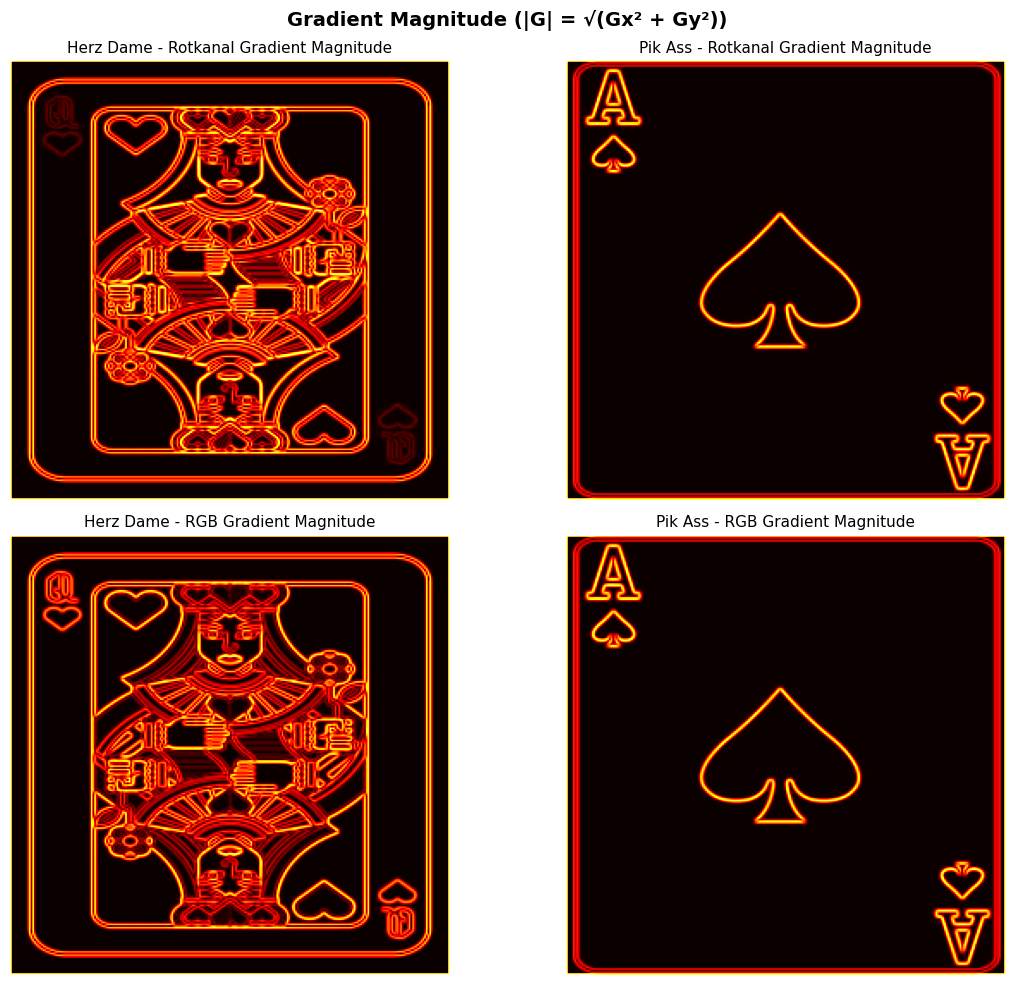

In [8]:
# Zusätzliche Visualisierung: Gradient Magnitude
# |G| = sqrt(Gx² + Gy²)
queen_red_magnitude = np.sqrt(queen_red_gx**2 + queen_red_gy**2)
queen_rgb_magnitude = np.sqrt(queen_rgb_gx**2 + queen_rgb_gy**2)
ace_red_magnitude = np.sqrt(ace_red_gx**2 + ace_red_gy**2)
ace_rgb_magnitude = np.sqrt(ace_rgb_gx**2 + ace_rgb_gy**2)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(queen_red_magnitude, cmap='hot')
axes[0, 0].set_title('Herz Dame - Rotkanal Gradient Magnitude', fontsize=11)
axes[0, 0].axis('off')

axes[0, 1].imshow(ace_red_magnitude, cmap='hot')
axes[0, 1].set_title('Pik Ass - Rotkanal Gradient Magnitude', fontsize=11)
axes[0, 1].axis('off')

axes[1, 0].imshow(queen_rgb_magnitude, cmap='hot')
axes[1, 0].set_title('Herz Dame - RGB Gradient Magnitude', fontsize=11)
axes[1, 0].axis('off')

axes[1, 1].imshow(ace_rgb_magnitude, cmap='hot')
axes[1, 1].set_title('Pik Ass - RGB Gradient Magnitude', fontsize=11)
axes[1, 1].axis('off')

plt.suptitle('Gradient Magnitude (|G| = √(Gx² + Gy²))', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Zusammenfassung

Das Notebook demonstriert:

1. **Bilddownload**: Spielkartenbilder (Herz Dame und Pik Ass) werden heruntergeladen
2. **Tensor-Konvertierung**: Bilder werden zu PyTorch Tensoren konvertiert (Shape: `(1, 3, H, W)`)
3. **Sobel Filter**: 
   - **Gx** (vertikale Kanten) und **Gy** (horizontale Kanten)
   - Angewendet auf den **Rotkanal** 
   - Angewendet auf **alle RGB-Kanäle**
4. **Conv2D Layer**: 
   - **Nur EINMAL** erstellt und aufgerufen
   - 3 Input-Kanäle (RGB)
   - 4 Output-Kanäle (Rotkanal Gx/Gy, RGB Gx/Gy)
   - Batch-Processing für beide Bilder gleichzeitig
5. **Visualisierung**: Matplotlib subplots zeigen Original und alle Filterergebnisse

**Wichtig**: Der Conv2D Layer wurde nur einmal instanziiert und nur einmal aufgerufen, um alle 4 Filteroperationen (2 auf Rotkanal, 2 auf RGB) für beide Bilder durchzuführen.